In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir, streetview_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader, load_demo
from M1_util_train_test import load_model

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
from setup import model_dir, image_dir, out_dir, data_dir
from util_model import parse_args

zoomlevel = 'zoom15'
latent_dim = 100
demo_dim = 7
demo_cols = [0,1,2,3,4,8,9]
# demo_cols = [0,9]
image_size = str(64)
im_norm = '2'
model_run_date = "2212c-dcgan-enc-2"
model_type = 'dcgan'
loss_func = 'mse'
model_class = 'gan'
base_lr = '0.0002'
weight_decay = '0'
sampling = 'clustered'

args = parse_args(s=['--zoomlevel', zoomlevel, '--latent_dim', str(latent_dim+demo_dim), 
                     '--image_size', image_size, \
                     '--im_norm', im_norm, '--model_run_date', model_run_date, '--model_type', model_type, \
                     '--loss_func', loss_func, '--model_class', model_class, \
                     '--base_lr', base_lr, '--weight_decay', weight_decay, \
                     '--demo_channels', str(demo_dim), \
                     '--sampling', sampling])

from util_model import dcgan_config, load_model

config = dcgan_config(args)

run_config = config['run_config']
optim_config = config['optim_config']
data_config = config['data_config']
model_config = config['model_config']

netD = load_model('dcgan', 'Discriminator', config)
netG = load_model('dcgan', 'Generator', config)

model_config['model_class'] == 'encoder'
netE = load_model('dcgan', 'Discriminator', 
                  {'model_config': {'base_channels':64, 'model_class':'encoder', 'latent_dim':latent_dim},
                   'data_config': {'color_channels':3}})

netD = netD.to(device)
netG = netG.to(device)
netE = netE.to(device)

In [4]:
# Satellite
train_loader, test_loader = image_loader(image_dir+args.zoomlevel+"/", data_dir, optim_config['batch_size'], 
         run_config['num_workers'], 
         data_config['image_size'], 
         data_version=args.data_version, 
         sampling=args.sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=args.im_norm,
         demo=True)

28280 images in dataset
3140 images in dataset


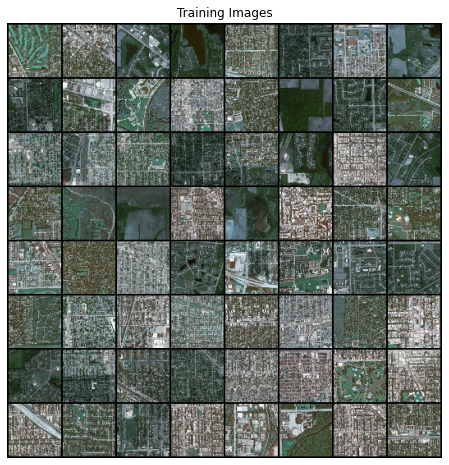

In [8]:
import torchvision.utils as vutils
temp = next(iter(train_loader))[1]
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(temp, padding=2, normalize=True).cpu(),(1,2,0)));

In [69]:
# Streetview
train_loader, test_loader = image_loader(streetview_dir, data_dir, 
                                         optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], 
                                         data_version=args.data_version, 
                                         sampling=args.sampling, 
                                         recalculate_normalize=False,
                                         image_type='jpg',
                                         augment=False,
                                         norm=args.im_norm,
                                         demo=True)

13761 images in dataset
1542 images in dataset


In [19]:
beta1 = 0.5
optimizerG = torch.optim.Adam([{'params': netG.parameters()}, {'params': list(netE.parameters()), 'lr': 1e-5}],
                          lr=optim_config['base_lr'], betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=optim_config['base_lr'], betas=(beta1, 0.999))


In [20]:
bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()

num_batches = len(train_loader)

In [ ]:
G_losses = []
D_losses = []
E_losses = []

real_label = 1
fake_label = 0

start_epoch = 0
iters = 0

for epoch in range(start_epoch, start_epoch+optim_config['epochs']):
    
    loss_d = 0
    loss_g = 0

    for step, (image_list, data, demo) in enumerate(train_loader):
#     for data, _ in celeb_train_loader:
        
        data = data.to(device)
        b_size = data.size(0)
        demo_conv = demo[:,:,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)
        
        for i in range(2):
        # alternate training between encoder and random
        
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            # concat demo with image
            real_cpu = torch.cat((data, demo_conv),1)
            real_cpu = real_cpu.float().to(device)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = bce_loss(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors

            if i == 0 :
                latent = torch.randn(b_size, latent_dim, 1, 1)
                latent = torch.cat((latent, demo[:,:,None,None]), 1)
                latent = latent.float().to(device)
            else:
                latent = netE(data)
                latent = torch.cat((latent, demo[:,:,None,None].to(device)), 1).float()

            # Generate fake image batch with G
            fake = netG(latent).float()
            fake_conv = torch.cat((fake, demo_conv), 1).float()
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake_conv.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = bce_loss(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

    #         loss_d += errD.item()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake_conv).view(-1)
            # Calculate G's loss based on this output
            errGD = bce_loss(output, label)
            if i == 0:
                errG = errGD
            else:
                errE = mse_loss(data, fake)
                errG = errGD + errE
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

    #         loss_g += errG.item()

            # Save Losses for plotting later
            if i == 1:
                G_losses.append(errGD.item())
                D_losses.append(errD.item())
                E_losses.append(errE.item())

                iters += 1
                if iters % 50 == 0:
                # Output training stats
                    print('[%d]\tLoss_E: %.4f\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, errE.item(), errD.item(), errGD.item(), D_x, D_G_z1, D_G_z2))


    # Check how the generator is doing by saving G's output on fixed_noise
    if epoch % 10 == 0:

#         with torch.no_grad():
#             fake = netG(fixed_noise).detach().cpu()

        plot = torch.cat([data[:8], fake[:8], data[8:16], fake[8:16], data[16:24], fake[16:24], data[24:32], fake[24:32]], dim=0)
        plot = plot.detach().cpu()
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        ax.axis("off")
        ax.set_title("Encoded Images")
        ax.imshow(np.transpose(torchvision.utils.make_grid(plot, padding=2, normalize=True).cpu(),(1,2,0)))
        fig.savefig(out_dir+"DCGAN/"+model_run_date+"/"+model_run_date+"_"+str(epoch)+".png", bbox_inches='tight')
        
        latent = torch.randn(b_size, latent_dim, 1, 1)
        latent = torch.cat((latent, demo[:,:,None,None]), 1)
        latent = latent.float().to(device)
        fake = netG(latent)

        fig, ax = plt.subplots(1,1,figsize=(8,8))
        ax.axis("off")
        ax.set_title("Sampled Images")
        ax.imshow(np.transpose(torchvision.utils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
        fig.savefig(out_dir+"DCGAN/"+model_run_date+"/"+model_run_date+"_rand_"+str(epoch)+".png", bbox_inches='tight')

#     print(epoch, loss_d/num_batches, loss_g/num_batches)
    
        if config['run_config']['save']:
            torch.save({'epoch': epoch,
                'generator_model_state_dict': netG.state_dict(),
                'encoder_model_state_dict': netE.state_dict(),
                'discriminator_model_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG,
                'optimizerD_state_dict': optimizerD,
                'config': config},
                model_dir+"DCGAN/"+model_run_date+"_"+str(epoch)+".pt")

[0]	Loss_E: 0.1026	Loss_D: 1.3868	Loss_G: 0.6943	D(x): 0.5017	D(G(z)): 0.5017 / 0.4995
[0]	Loss_E: 0.0920	Loss_D: 1.3906	Loss_G: 0.6948	D(x): 0.5012	D(G(z)): 0.5012 / 0.5007
[0]	Loss_E: 0.0910	Loss_D: 1.3881	Loss_G: 0.6943	D(x): 0.5051	D(G(z)): 0.5051 / 0.4997
[0]	Loss_E: 0.0953	Loss_D: 1.3864	Loss_G: 0.6885	D(x): 0.5025	D(G(z)): 0.5025 / 0.5024
[0]	Loss_E: 0.0893	Loss_D: 1.3880	Loss_G: 0.6908	D(x): 0.5037	D(G(z)): 0.5037 / 0.5018
[0]	Loss_E: 0.0869	Loss_D: 1.3876	Loss_G: 0.6893	D(x): 0.4889	D(G(z)): 0.4889 / 0.5022
[0]	Loss_E: 0.0859	Loss_D: 1.3900	Loss_G: 0.7153	D(x): 0.5082	D(G(z)): 0.5082 / 0.4903
[0]	Loss_E: 0.0881	Loss_D: 1.3870	Loss_G: 0.6965	D(x): 0.5006	D(G(z)): 0.5006 / 0.4984
[1]	Loss_E: 0.0957	Loss_D: 1.3863	Loss_G: 0.6960	D(x): 0.4984	D(G(z)): 0.4984 / 0.4986
[1]	Loss_E: 0.0864	Loss_D: 1.3863	Loss_G: 0.6940	D(x): 0.5021	D(G(z)): 0.5021 / 0.4996
[1]	Loss_E: 0.0860	Loss_D: 1.3869	Loss_G: 0.7007	D(x): 0.5098	D(G(z)): 0.5098 / 0.4963
[1]	Loss_E: 0.0830	Loss_D: 1.3864	Loss_G: 0

[10]	Loss_E: 0.0757	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[10]	Loss_E: 0.0807	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[11]	Loss_E: 0.0764	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[11]	Loss_E: 0.0770	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.4998	D(G(z)): 0.4998 / 0.5003
[11]	Loss_E: 0.0739	Loss_D: 1.3863	Loss_G: 0.6920	D(x): 0.5004	D(G(z)): 0.5004 / 0.5006
[11]	Loss_E: 0.0763	Loss_D: 1.3863	Loss_G: 0.6943	D(x): 0.5003	D(G(z)): 0.5003 / 0.4994
[11]	Loss_E: 0.0718	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.5002	D(G(z)): 0.5002 / 0.4999
[11]	Loss_E: 0.0697	Loss_D: 1.3863	Loss_G: 0.6936	D(x): 0.5002	D(G(z)): 0.5002 / 0.4998
[11]	Loss_E: 0.0732	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.4998	D(G(z)): 0.4998 / 0.5000
[11]	Loss_E: 0.0733	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[11]	Loss_E: 0.0786	Loss_D: 1.3863	Loss_G: 0.6935	D(x): 0.5002	D(G(z)): 0.5002 / 0.4998
[12]	Loss_E: 0.0751	Loss_D: 1.38

[21]	Loss_E: 0.0775	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.5001	D(G(z)): 0.5001 / 0.5003
[21]	Loss_E: 0.0742	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[21]	Loss_E: 0.0690	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[21]	Loss_E: 0.0744	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[21]	Loss_E: 0.0745	Loss_D: 1.3863	Loss_G: 0.6925	D(x): 0.5001	D(G(z)): 0.5001 / 0.5003
[22]	Loss_E: 0.0706	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.4998	D(G(z)): 0.4998 / 0.5001
[22]	Loss_E: 0.0712	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[22]	Loss_E: 0.0705	Loss_D: 1.3863	Loss_G: 0.6927	D(x): 0.4993	D(G(z)): 0.4993 / 0.5002
[22]	Loss_E: 0.0754	Loss_D: 1.3863	Loss_G: 0.6934	D(x): 0.5001	D(G(z)): 0.5001 / 0.4999
[22]	Loss_E: 0.0632	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.4998	D(G(z)): 0.4998 / 0.5001
[22]	Loss_E: 0.0647	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5002	D(G(z)): 0.5002 / 0.5001
[22]	Loss_E: 0.0598	Loss_D: 1.38

[32]	Loss_E: 0.0703	Loss_D: 1.3863	Loss_G: 0.6928	D(x): 0.4999	D(G(z)): 0.4999 / 0.5002
[32]	Loss_E: 0.0648	Loss_D: 1.3863	Loss_G: 0.6937	D(x): 0.5000	D(G(z)): 0.5000 / 0.4997
[32]	Loss_E: 0.0688	Loss_D: 1.3863	Loss_G: 0.6928	D(x): 0.5000	D(G(z)): 0.5000 / 0.5002
[32]	Loss_E: 0.0650	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.4997	D(G(z)): 0.4997 / 0.5003
[32]	Loss_E: 0.0623	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5001	D(G(z)): 0.5001 / 0.5000
[32]	Loss_E: 0.0686	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.5001	D(G(z)): 0.5001 / 0.4999
[32]	Loss_E: 0.0561	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.4995	D(G(z)): 0.4995 / 0.5003
[32]	Loss_E: 0.0684	Loss_D: 1.3863	Loss_G: 0.6939	D(x): 0.4997	D(G(z)): 0.4997 / 0.4996
[33]	Loss_E: 0.0709	Loss_D: 1.3863	Loss_G: 0.6928	D(x): 0.5000	D(G(z)): 0.5000 / 0.5002
[33]	Loss_E: 0.0665	Loss_D: 1.3863	Loss_G: 0.6936	D(x): 0.4999	D(G(z)): 0.4999 / 0.4998
[33]	Loss_E: 0.0686	Loss_D: 1.3863	Loss_G: 0.6947	D(x): 0.5001	D(G(z)): 0.5001 / 0.4992
[33]	Loss_E: 0.0686	Loss_D: 1.38

[42]	Loss_E: 0.0694	Loss_D: 1.3863	Loss_G: 0.6937	D(x): 0.5000	D(G(z)): 0.5000 / 0.4997
[42]	Loss_E: 0.0636	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[42]	Loss_E: 0.0662	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5003	D(G(z)): 0.5003 / 0.5000
[43]	Loss_E: 0.0679	Loss_D: 1.3863	Loss_G: 0.6928	D(x): 0.4999	D(G(z)): 0.4999 / 0.5002
[43]	Loss_E: 0.0612	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[43]	Loss_E: 0.0695	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.4999
[43]	Loss_E: 0.0657	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[43]	Loss_E: 0.0673	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[43]	Loss_E: 0.0688	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5001	D(G(z)): 0.5001 / 0.5000
[43]	Loss_E: 0.0674	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[43]	Loss_E: 0.0674	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.4998	D(G(z)): 0.4998 / 0.4999
[44]	Loss_E: 0.0646	Loss_D: 1.38

[53]	Loss_E: 0.0668	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.4999	D(G(z)): 0.4999 / 0.5000
[53]	Loss_E: 0.0663	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[53]	Loss_E: 0.0581	Loss_D: 1.3863	Loss_G: 0.6936	D(x): 0.4998	D(G(z)): 0.4998 / 0.4998
[53]	Loss_E: 0.0629	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5001	D(G(z)): 0.5001 / 0.5000
[53]	Loss_E: 0.0631	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.5001	D(G(z)): 0.5001 / 0.4999
[53]	Loss_E: 0.0613	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5002	D(G(z)): 0.5002 / 0.5000
[54]	Loss_E: 0.0641	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[54]	Loss_E: 0.0562	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.5000	D(G(z)): 0.5000 / 0.4999
[54]	Loss_E: 0.0623	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[54]	Loss_E: 0.0635	Loss_D: 1.3863	Loss_G: 0.6923	D(x): 0.5005	D(G(z)): 0.5005 / 0.5004
[54]	Loss_E: 0.0583	Loss_D: 1.3863	Loss_G: 0.6928	D(x): 0.5002	D(G(z)): 0.5002 / 0.5002
[54]	Loss_E: 0.0660	Loss_D: 1.38

[64]	Loss_E: 0.0585	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[64]	Loss_E: 0.0712	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[64]	Loss_E: 0.0562	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.5002	D(G(z)): 0.5002 / 0.4999
[64]	Loss_E: 0.0630	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[64]	Loss_E: 0.0627	Loss_D: 1.3863	Loss_G: 0.6935	D(x): 0.5000	D(G(z)): 0.5000 / 0.4998
[64]	Loss_E: 0.0616	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.4999	D(G(z)): 0.4999 / 0.5001
[64]	Loss_E: 0.0638	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.5000	D(G(z)): 0.5000 / 0.4999
[64]	Loss_E: 0.0587	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[64]	Loss_E: 0.0631	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.4999	D(G(z)): 0.4999 / 0.5001
[65]	Loss_E: 0.0605	Loss_D: 1.3863	Loss_G: 0.6934	D(x): 0.5000	D(G(z)): 0.5000 / 0.4999
[65]	Loss_E: 0.0618	Loss_D: 1.3863	Loss_G: 0.6936	D(x): 0.5002	D(G(z)): 0.5002 / 0.4998
[65]	Loss_E: 0.0607	Loss_D: 1.38

[74]	Loss_E: 0.0581	Loss_D: 1.3863	Loss_G: 0.6925	D(x): 0.5004	D(G(z)): 0.5004 / 0.5003
[74]	Loss_E: 0.0620	Loss_D: 1.3863	Loss_G: 0.6934	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[74]	Loss_E: 0.0656	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.4998	D(G(z)): 0.4998 / 0.5000
[74]	Loss_E: 0.0607	Loss_D: 1.3863	Loss_G: 0.6928	D(x): 0.5002	D(G(z)): 0.5002 / 0.5002
[75]	Loss_E: 0.0579	Loss_D: 1.3863	Loss_G: 0.6934	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[75]	Loss_E: 0.0580	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5002	D(G(z)): 0.5002 / 0.5000
[75]	Loss_E: 0.0599	Loss_D: 1.3863	Loss_G: 0.6938	D(x): 0.4996	D(G(z)): 0.4996 / 0.4997
[75]	Loss_E: 0.0584	Loss_D: 1.3863	Loss_G: 0.6938	D(x): 0.4994	D(G(z)): 0.4994 / 0.4997
[75]	Loss_E: 0.0587	Loss_D: 1.3864	Loss_G: 0.6943	D(x): 0.4995	D(G(z)): 0.4996 / 0.4994
[75]	Loss_E: 0.0557	Loss_D: 1.3863	Loss_G: 0.6934	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[75]	Loss_E: 0.0578	Loss_D: 1.3863	Loss_G: 0.6942	D(x): 0.4995	D(G(z)): 0.4995 / 0.4995
[75]	Loss_E: 0.0606	Loss_D: 1.38

[85]	Loss_E: 0.0589	Loss_D: 1.3867	Loss_G: 0.6934	D(x): 0.5002	D(G(z)): 0.5004 / 0.4999
[85]	Loss_E: 0.0590	Loss_D: 1.3867	Loss_G: 0.6934	D(x): 0.5008	D(G(z)): 0.5010 / 0.4999
[85]	Loss_E: 0.0641	Loss_D: 1.3864	Loss_G: 0.6935	D(x): 0.4997	D(G(z)): 0.4997 / 0.4998
[85]	Loss_E: 0.0604	Loss_D: 1.3872	Loss_G: 0.6915	D(x): 0.4994	D(G(z)): 0.4997 / 0.5009
[85]	Loss_E: 0.0555	Loss_D: 1.3863	Loss_G: 0.6966	D(x): 0.4986	D(G(z)): 0.4986 / 0.4983
[85]	Loss_E: 0.0618	Loss_D: 1.3865	Loss_G: 0.6964	D(x): 0.4980	D(G(z)): 0.4981 / 0.4984
[85]	Loss_E: 0.0559	Loss_D: 1.3865	Loss_G: 0.6925	D(x): 0.5010	D(G(z)): 0.5010 / 0.5003
[86]	Loss_E: 0.0598	Loss_D: 1.3863	Loss_G: 0.6924	D(x): 0.5004	D(G(z)): 0.5004 / 0.5004
[86]	Loss_E: 0.0583	Loss_D: 1.3864	Loss_G: 0.6925	D(x): 0.5000	D(G(z)): 0.5000 / 0.5003
[86]	Loss_E: 0.0610	Loss_D: 1.3864	Loss_G: 0.6927	D(x): 0.5007	D(G(z)): 0.5008 / 0.5002
[86]	Loss_E: 0.0582	Loss_D: 1.3864	Loss_G: 0.6929	D(x): 0.4998	D(G(z)): 0.4998 / 0.5001
[86]	Loss_E: 0.0611	Loss_D: 1.38

[95]	Loss_E: 0.0574	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.5002	D(G(z)): 0.5002 / 0.5003
[96]	Loss_E: 0.0551	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5001	D(G(z)): 0.5001 / 0.5001
[96]	Loss_E: 0.0594	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.4999	D(G(z)): 0.4999 / 0.5000
[96]	Loss_E: 0.0594	Loss_D: 1.3863	Loss_G: 0.6949	D(x): 0.5005	D(G(z)): 0.5005 / 0.4992
[96]	Loss_E: 0.0517	Loss_D: 1.3863	Loss_G: 0.6943	D(x): 0.4995	D(G(z)): 0.4995 / 0.4994
[96]	Loss_E: 0.0616	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5002	D(G(z)): 0.5002 / 0.5001
[96]	Loss_E: 0.0623	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[96]	Loss_E: 0.0604	Loss_D: 1.3863	Loss_G: 0.6934	D(x): 0.4997	D(G(z)): 0.4997 / 0.4999
[96]	Loss_E: 0.0558	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5002	D(G(z)): 0.5002 / 0.5001
[96]	Loss_E: 0.0586	Loss_D: 1.3864	Loss_G: 0.6903	D(x): 0.5025	D(G(z)): 0.5025 / 0.5014
[97]	Loss_E: 0.0547	Loss_D: 1.3863	Loss_G: 0.6936	D(x): 0.4994	D(G(z)): 0.4994 / 0.4998
[97]	Loss_E: 0.0520	Loss_D: 1.38

<ipython-input-21-c3f5e3b1fecd>:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=(8,8))


[101]	Loss_E: 0.0603	Loss_D: 1.3863	Loss_G: 0.6941	D(x): 0.4994	D(G(z)): 0.4994 / 0.4995
[101]	Loss_E: 0.0602	Loss_D: 1.3863	Loss_G: 0.6929	D(x): 0.5001	D(G(z)): 0.5001 / 0.5001
[101]	Loss_E: 0.0558	Loss_D: 1.3863	Loss_G: 0.6963	D(x): 0.4988	D(G(z)): 0.4988 / 0.4984
[101]	Loss_E: 0.0577	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.4999	D(G(z)): 0.4999 / 0.5000
[101]	Loss_E: 0.0605	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.4998	D(G(z)): 0.4999 / 0.5000
[101]	Loss_E: 0.0541	Loss_D: 1.3864	Loss_G: 0.6938	D(x): 0.5001	D(G(z)): 0.5001 / 0.4997
[101]	Loss_E: 0.0570	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[101]	Loss_E: 0.0551	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[101]	Loss_E: 0.0594	Loss_D: 1.3863	Loss_G: 0.6936	D(x): 0.4995	D(G(z)): 0.4995 / 0.4998
[102]	Loss_E: 0.0530	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[102]	Loss_E: 0.0600	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5005	D(G(z)): 0.5005 / 0.5000
[102]	Loss_E: 0.0599	

[111]	Loss_E: 0.0569	Loss_D: 1.3863	Loss_G: 0.6913	D(x): 0.5010	D(G(z)): 0.5010 / 0.5009
[111]	Loss_E: 0.0586	Loss_D: 1.3863	Loss_G: 0.6918	D(x): 0.5003	D(G(z)): 0.5003 / 0.5007
[111]	Loss_E: 0.0635	Loss_D: 1.3865	Loss_G: 0.6926	D(x): 0.4992	D(G(z)): 0.4993 / 0.5003
[111]	Loss_E: 0.0609	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[111]	Loss_E: 0.0582	Loss_D: 1.3863	Loss_G: 0.6947	D(x): 0.4990	D(G(z)): 0.4990 / 0.4992
[112]	Loss_E: 0.0633	Loss_D: 1.3863	Loss_G: 0.6919	D(x): 0.5010	D(G(z)): 0.5010 / 0.5006
[112]	Loss_E: 0.0520	Loss_D: 1.3863	Loss_G: 0.6925	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[112]	Loss_E: 0.0597	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5001	D(G(z)): 0.5001 / 0.5001
[112]	Loss_E: 0.0565	Loss_D: 1.3863	Loss_G: 0.6937	D(x): 0.4997	D(G(z)): 0.4997 / 0.4997
[112]	Loss_E: 0.0559	Loss_D: 1.3863	Loss_G: 0.6925	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[112]	Loss_E: 0.0604	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5001	D(G(z)): 0.5001 / 0.5000
[112]	Loss_E: 0.0610	

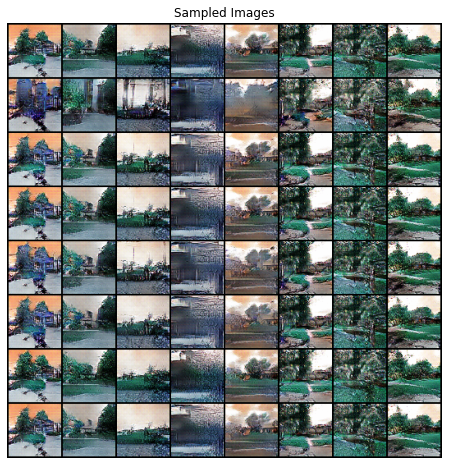

In [72]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.axis("off")
ax.set_title("Sampled Images")
ax.imshow(np.transpose(torchvision.utils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
# fig.savefig(out_dir+"GAN_"+zoomlevel+"_"+str(model_config['latent_dim'])+"_"+
#     model_run_date+".png", bbox_inches='tight')


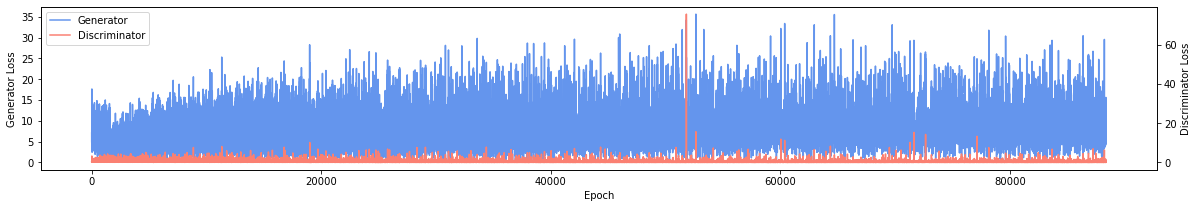

In [19]:
fig, ax = plt.subplots(1, figsize=(20,3))
ln1 = ax.plot(G_losses, label='Generator', color='cornflowerblue')
ax2 = ax.twinx()
ln2 = ax2.plot(D_losses, label='Discriminator', color='salmon')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel("Epoch")
ax.set_ylabel("Generator Loss")
ax2.set_ylabel("Discriminator Loss")

# fig.savefig(out_dir+"training_plots/"+model_type+"_"+zoomlevel+"_"+str(latent_dim)+"_"+
#                 model_save_variable_names[y]+"_"+model_run_date+".png", bbox_inches='tight')
plt.show()
